# Simple deep multi-layer perceptron classification with Earth Engine and Keras

This notebook walks you through a simple example of using Earth Engine and Keras.

Specifically, we will train a neural network to recognize cloudy pixels in a Landsat scene. For this simple example we will use the output of the Fmask cloud detection algorithm as training data.

## Configure the Environment

We begin by importing a number of useful libraries

In [3]:
import ee
from IPython import display
import math
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import tensorflow as tf
#from osgeo import gdal
import urllib.request
import zipfile

Initialize the Earth Engine client.

In [4]:
ee.Initialize()

## Inspect the Input Data

Load a Landsat image with corresponding Fmask label data.

In [5]:
input_image = ee.Image('LANDSAT/LT5_L1T_TOA_FMASK/LT50100551998003CPE00')


Let's define a helper function to make it easier to print thumbnails of Earth Engine images. (We'll be adding a library with utility functions like this one to the Earth Engine Python SDK, but for now we can do it by hand.)

In [6]:
def print_image(image):
  display.display(display.Image(ee.data.getThumbnail({
      'image': image.serialize(),
      'dimensions': '360',
  })))

Now we can use our helper function to quickly visualize the image and label data. The Fmask values are:

| 0  | 1 | 2  | 3 | 4 |
| ------- | ------- | ------- | ------- | ------- |
| Clear  | Water  | Shadow  | Snow  | Cloud  |

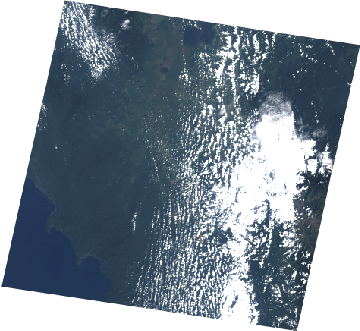

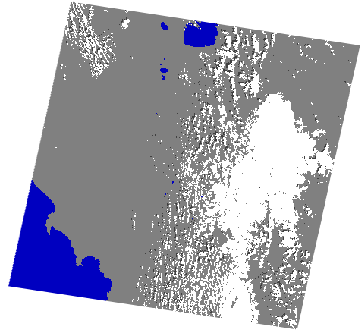

In [7]:

print_image(input_image.visualize(
    bands=['B3', 'B2', 'B1'],
    min=0,
    max=0.3,
))
print_image(input_image.visualize(
    bands=['fmask'],
    min=0,
    max=4,
    palette=['808080', '0000C0', '404040', '00FFFF', 'FFFFFF'],
))

## Fetch the Input Data

First we define some helper functions to download raw data from Earth Engine as numpy arrays.

We use the getDownloadId() function, which only works for modestly sized datasets. For larger datasets, a better approach would be to initiate a batch Export from Earth Engine to Cloud Storage, which you could easily manage right here in Datalab too.

In [8]:
def download_tif(image, scale):
  url = ee.data.makeDownloadUrl(ee.data.getDownloadId({
        'image': image.serialize(),
        'scale': '%d' % scale,
        'filePerBand': 'false',
        'name': 'data',
  }))
  local_zip, headers = urllib.request.urlretrieve(url)
  with zipfile.ZipFile(local_zip) as local_zipfile:
    return local_zipfile.extract('data.tif', tempfile.mkdtemp())

def load_image(image, scale):
  local_tif_filename = download_tif(image, scale)
  dataset = gdal.Open(local_tif_filename, gdal.GA_ReadOnly)
  bands = [dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(dataset.RasterCount)]
  return np.stack(bands, 2)

Now we can use that function to load the data from Earth Engine, including a valid data band, as a numpy array. This may take a few seconds. We also convert the Fmask band to a binary cloud label (i.e. fmask=4).

In [9]:
mask = input_image.mask().reduce('min')
data = load_image(input_image.addBands(mask), scale=240)
data[:,:,7] = np.equal(data[:,:,7], 4)

NameError: name 'gdal' is not defined

Display the local data. This time, for variety, we display it as an NRG false-color image. 

In [ ]:
plt.imshow(np.clip(data[:,:,[3,2,1]] * 3, 0, 1))

Display the cloud mask

In [ ]:
plt.imshow(data[:,:,7])

## Preprocess input data for Keras

Select the valid pixels and hold out a fraction for use as validation data. Convert the input to float32 and normalize our data values to the range [0, 1].

In [ ]:
fraction  = 0.1

# Reshape into a single vector of pixels.
data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

# Select only the valid data and shuffle it.
valid_data = data_vector[numpy.equal(data_vector[:,8], 1)]
numpy.random.shuffle(valid_data)

# Normalize the first 7 chanels to the range [0, 1]
data_min = valid_data[:,0:7].min(0)
data_max = valid_data[:,0:7].max(0)
valid_data[:,0:7] = (valid_data[:,0:7]-data_min)/(data_max-data_min)

# Hold out a fraction of the labeled data for validation.
training_size = int(valid_data.shape[0] * (1 - fraction))
training_data = valid_data[0:training_size,:].astype('float32')
validation_data = valid_data[training_size:-1,:].astype('float32')

# Split the data into the input and output
x_train = training_data[:,0:7]
y_train = training_data[:,7].reshape(training_data[:,7].shape[0],1)

x_test = validation_data[:,0:7]
y_test = validation_data[:,7].reshape(validation_data[:,7].shape[0],1)

In [ ]:
print('X shape:', x_train.shape, 'Y shape:', y_train.shape )

The y_train and y_test data are not split into 2 distinct class labels, but rather are represented as a single array with the class values. We can fix this easily:

In [ ]:
# convert class vectors to binary class matrices
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [ ]:
print('Y shape:', y_test.shape )

## Define the Keras model

Here we define a neural network with two hidden layers with `relu` nonlinearities.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

batch_size = 32
num_classes = 2
epochs = 1

model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(7,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

**Compile the model**

In [ ]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

**Train the Neural Network**

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

**Evaluate the model**

In [ ]:
# Evaluate Keras model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

**Predict**

In [ ]:
y_output = model.predict(x_test, batch_size=batch_size, verbose=0)